In [1]:


!pip install -q transformers datasets evaluate scikit-learn accelerate psutil

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time, psutil, os, torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [2]:


dataset = load_dataset("ucberkeley-dlab/measuring-hate-speech")

# Create 80/20 split because dataset only has 'train'
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Rename test → validation (optional, matches your earlier code)
dataset["validation"] = dataset.pop("test")

dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

measuring-hate-speech.parquet:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/135556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [3]:

def encode_labels(example):
    score = example["hate_speech_score"]
    if score < 0.3:
        example["label"] = 0
    elif score < 0.7:
        example["label"] = 1
    else:
        example["label"] = 2
    return example

dataset = dataset.map(encode_labels)

# Keep only text + label
dataset = dataset.remove_columns(
    [col for col in dataset["train"].column_names if col not in ["text", "label"]]
)


checkpoint_distilbert = "distilbert-base-uncased"
checkpoint_minilm = "microsoft/MiniLM-L12-H384-uncased"
checkpoint_albert = "albert-base-v2"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_distilbert)


def preprocess(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess, batched=True).remove_columns(["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/27112 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/27112 [00:00<?, ? examples/s]

In [4]:


accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels),
        "precision": precision.compute(predictions=preds, references=labels, average="weighted"),
        "recall": recall.compute(predictions=preds, references=labels, average="weighted"),
        "f1": f1.compute(predictions=preds, references=labels, average="weighted"),
    }


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1476976112.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
200,0.590000
400,0.465200
600,0.450600
800,0.401600
1000,0.379900
1200,0.378200
1400,0.367300
1600,0.383400
1800,0.371000
2000,0.376400


Trainer is attempting to log a value of "{'accuracy': 0.9487680731779286}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9482973974683065}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9487680731779286}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9485145328426287}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.224882110953331, 'eval_accuracy': {'accuracy': 0.9487680731779286}, 'eval_precision': {'precision': 0.9482973974683065}, 'eval_recall': {'recall': 0.9487680731779286}, 'eval_f1': {'f1': 0.9485145328426287}, 'eval_runtime': 76.6609, 'eval_samples_per_second': 353.661, 'eval_steps_per_second': 22.11, 'epoch': 3.0}


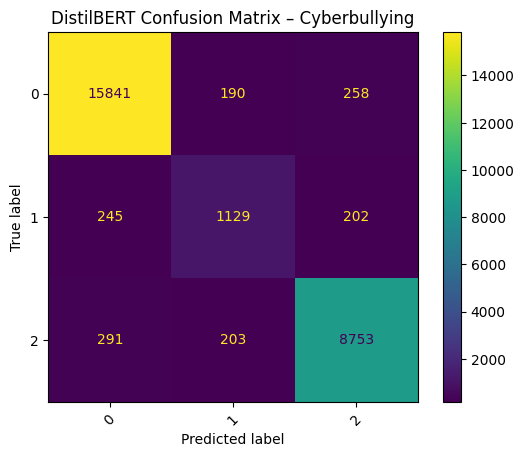

In [5]:

model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_distilbert,
    num_labels=3,
)


training_args_distilbert = TrainingArguments(
    output_dir="./results_distilbert_cyber",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=200,
    do_eval=True,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args_distilbert,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_distilbert.train()
results_distilbert = trainer_distilbert.evaluate()
results_distilbert

print(results_distilbert)

preds_output = trainer_distilbert.predict(tokenized_dataset["validation"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("DistilBERT Confusion Matrix – Cyberbullying")
plt.show()



tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/27112 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1037815853.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_minilm = Trainer(


Step,Training Loss
200,0.748100
400,0.568600
600,0.517400
800,0.464000
1000,0.433300
1200,0.436800
1400,0.416000
1600,0.424900
1800,0.425400
2000,0.442900


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Trainer is attempting to log a value of "{'accuracy': 0.9057612865151963}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8972599655582467}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9057612865151963}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9000622251467048}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.27469226717948914, 'eval_accuracy': {'accuracy': 0.9057612865151963}, 'eval_precision': {'precision': 0.8972599655582467}, 'eval_recall': {'recall': 0.9057612865151963}, 'eval_f1': {'f1': 0.9000622251467048}, 'eval_runtime': 49.3476, 'eval_samples_per_second': 549.409, 'eval_steps_per_second': 34.348, 'epoch': 3.0}


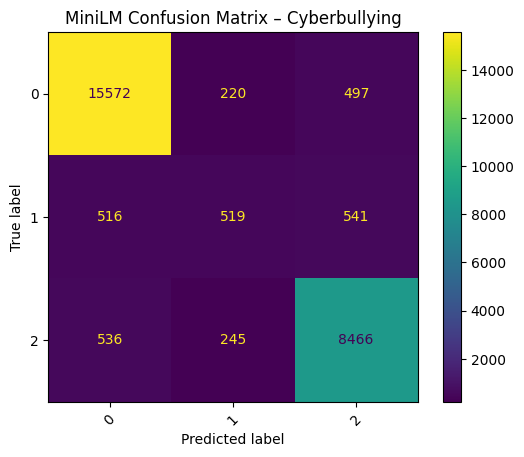

In [6]:


tokenizer_minilm = AutoTokenizer.from_pretrained(checkpoint_minilm)

tokenized_dataset_minilm = dataset.map(
    lambda batch: tokenizer_minilm(batch["text"], truncation=True, max_length=512),
    batched=True
).remove_columns(["text"])

model_minilm = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_minilm,
    num_labels=3,
)

training_args_minilm = TrainingArguments(
    output_dir="./results_minilm_cyber",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=200,
    do_eval=True,
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args_minilm,
    train_dataset=tokenized_dataset_minilm["train"],
    eval_dataset=tokenized_dataset_minilm["validation"],
    tokenizer=tokenizer_minilm,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_minilm),
    compute_metrics=compute_metrics,
)

trainer_minilm.train()
results_minilm = trainer_minilm.evaluate()
print(results_minilm)

preds_output = trainer_minilm.predict(tokenized_dataset_minilm["validation"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("MiniLM Confusion Matrix – Cyberbullying")
plt.show()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/27112 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3147788570.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_albert = Trainer(


Step,Training Loss
200,0.618600
400,0.525300
600,0.501500
800,0.441300
1000,0.420900
1200,0.417500
1400,0.400700
1600,0.414000
1800,0.402200
2000,0.411500


Trainer is attempting to log a value of "{'accuracy': 0.9506860430805547}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9499293566160296}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9506860430805547}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9501396984007261}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2546263635158539, 'eval_accuracy': {'accuracy': 0.9506860430805547}, 'eval_precision': {'precision': 0.9499293566160296}, 'eval_recall': {'recall': 0.9506860430805547}, 'eval_f1': {'f1': 0.9501396984007261}, 'eval_runtime': 175.7221, 'eval_samples_per_second': 154.289, 'eval_steps_per_second': 9.646, 'epoch': 3.0}


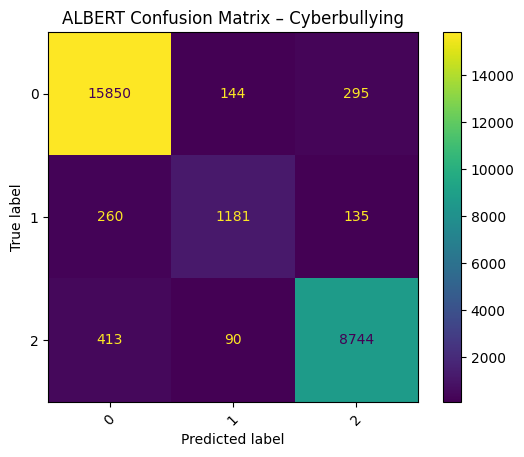

In [7]:


tokenizer_albert = AutoTokenizer.from_pretrained(checkpoint_albert)

tokenized_dataset_albert = dataset.map(
    lambda batch: tokenizer_albert(batch["text"], truncation=True),
    batched=True
).remove_columns(["text"])

model_albert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_albert,
    num_labels=3,
)

training_args_albert = TrainingArguments(
    output_dir="./results_albert_cyber",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=200,
    do_eval=True,
)

trainer_albert = Trainer(
    model=model_albert,
    args=training_args_albert,
    train_dataset=tokenized_dataset_albert["train"],
    eval_dataset=tokenized_dataset_albert["validation"],
    tokenizer=tokenizer_albert,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_albert),
    compute_metrics=compute_metrics,
)

trainer_albert.train()
results_albert = trainer_albert.evaluate()
print(results_albert)

preds_output = trainer_albert.predict(tokenized_dataset_albert["validation"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("ALBERT Confusion Matrix – Cyberbullying")
plt.show()


In [8]:


print("=== Efficiency Metrics — DistilBERT (Cyberbullying) ===")

# 1) Model size
params_distilbert = sum(p.numel() for p in model_distilbert.parameters())
size_mb_distilbert = params_distilbert * 4 / (1024 * 1024)
print(f"Model Size: {size_mb_distilbert:.2f} MB")

model_minilm.config.id2label = {0: "Neutral", 1: "Offensive", 2: "Hate Speech"}
model_minilm.config.label2id = {"Neutral": 0, "Offensive": 1, "Hate Speech": 2}

# 2) Training time from logs
train_time_distilbert = None
for entry in reversed(trainer_distilbert.state.log_history):
    if "train_runtime" in entry:
        train_time_distilbert = entry["train_runtime"]
        break

if train_time_distilbert is not None:
    print(f"Training Time: {train_time_distilbert:.2f} seconds")
else:
    print("Training Time: Not available")

# 3) Inference time & 4) Throughput
test_subset = tokenized_dataset["validation"].select(range(min(200, len(tokenized_dataset["validation"]))))

start = time.time()
pred_output = trainer_distilbert.predict(test_subset)
end = time.time()

inf_time_ms = (end - start) / len(test_subset) * 1000
throughput = len(test_subset) / (end - start)

print(f"Inference Time Per Sample: {inf_time_ms:.4f} ms")
print(f"Throughput: {throughput:.2f} samples/sec")

# 5) RAM
process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_mb:.2f} MB")

# 6) GPU memory
if torch.cuda.is_available():
    gpu_mb = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mb:.2f} MB")
else:
    print("GPU not available")

# 7) Energy estimate (optional)
GPU_TDP = 70  # watts for T4 approx
energy_joules = GPU_TDP * (train_time_distilbert or 0)
print(f"Approx Energy Used (Training): {energy_joules:.2f} Joules")


=== Efficiency Metrics — DistilBERT (Cyberbullying) ===
Model Size: 255.42 MB
Training Time: 3644.40 seconds


Inference Time Per Sample: 2.7119 ms
Throughput: 368.75 samples/sec
RAM Usage During Evaluation: 2601.98 MB
GPU Memory Allocated: 1314.89 MB
Approx Energy Used (Training): 255108.32 Joules


In [9]:


print("=== Efficiency Metrics — MiniLM (Cyberbullying) ===")

params_minilm = sum(p.numel() for p in model_minilm.parameters())
size_mb_minilm = params_minilm * 4 / (1024 * 1024)
print(f"Model Size: {size_mb_minilm:.2f} MB")

train_time_minilm = None
for entry in reversed(trainer_minilm.state.log_history):
    if "train_runtime" in entry:
        train_time_minilm = entry["train_runtime"]
        break

if train_time_minilm is not None:
    print(f"Training Time: {train_time_minilm:.2f} seconds")
else:
    print("Training Time: Not available")

test_subset_minilm = tokenized_dataset_minilm["validation"].select(
    range(min(200, len(tokenized_dataset_minilm["validation"])))
)

start = time.time()
pred_output = trainer_minilm.predict(test_subset_minilm)
end = time.time()

inf_time_ms = (end - start) / len(test_subset_minilm) * 1000
throughput = len(test_subset_minilm) / (end - start)

print(f"Inference Time Per Sample: {inf_time_ms:.4f} ms")
print(f"Throughput: {throughput:.2f} samples/sec")

process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_mb:.2f} MB")

if torch.cuda.is_available():
    gpu_mb = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mb:.2f} MB")
else:
    print("GPU not available")

GPU_TDP = 70
energy_joules = GPU_TDP * (train_time_minilm or 0)
print(f"Approx Energy Used (Training): {energy_joules:.2f} Joules")


=== Efficiency Metrics — MiniLM (Cyberbullying) ===
Model Size: 127.26 MB
Training Time: 2161.34 seconds


Inference Time Per Sample: 1.8513 ms
Throughput: 540.17 samples/sec
RAM Usage During Evaluation: 2602.32 MB
GPU Memory Allocated: 1314.89 MB
Approx Energy Used (Training): 151293.58 Joules


In [10]:


print("=== Efficiency Metrics — ALBERT (Cyberbullying) ===")

params_albert = sum(p.numel() for p in model_albert.parameters())
size_mb_albert = params_albert * 4 / (1024 * 1024)
print(f"Model Size: {size_mb_albert:.2f} MB")

train_time_albert = None
for entry in reversed(trainer_albert.state.log_history):
    if "train_runtime" in entry:
        train_time_albert = entry["train_runtime"]
        break

if train_time_albert is not None:
    print(f"Training Time: {train_time_albert:.2f} seconds")
else:
    print("Training Time: Not available")

# FIXED: No 'test' split, use validation
test_subset_albert = tokenized_dataset_albert["validation"].select(
    range(min(200, len(tokenized_dataset_albert["validation"])))
)

start = time.time()
pred_output = trainer_albert.predict(test_subset_albert)
end = time.time()

inf_time_ms = (end - start) / len(test_subset_albert) * 1000
throughput = len(test_subset_albert) / (end - start)

print(f"Inference Time Per Sample: {inf_time_ms:.4f} ms")
print(f"Throughput: {throughput:.2f} samples/sec")

process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage During Evaluation: {ram_mb:.2f} MB")

if torch.cuda.is_available():
    gpu_mb = torch.cuda.memory_allocated(0) / (1024 * 1024)
    print(f"GPU Memory Allocated: {gpu_mb:.2f} MB")
else:
    print("GPU not available")

GPU_TDP = 70
energy_joules = GPU_TDP * (train_time_albert or 0)
print(f"Approx Energy Used (Training): {energy_joules:.2f} Joules")


=== Efficiency Metrics — ALBERT (Cyberbullying) ===
Model Size: 44.58 MB
Training Time: 5863.78 seconds


Inference Time Per Sample: 6.1534 ms
Throughput: 162.51 samples/sec
RAM Usage During Evaluation: 2602.37 MB
GPU Memory Allocated: 1314.89 MB
Approx Energy Used (Training): 410464.36 Joules
